In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np

# 1. 원본 이미지 로드
img = cv2.imread('/content/drive/MyDrive/NASA2024/OriginalGalaxyView.png')

# 2. 그레이스케일 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 3. 가우시안 블러 적용
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 4. 이진화 적용
threshold_value = 22  # 필요에 따라 조정
_, thresh = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY)

# 5. 모폴로지 연산
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
kernel_small = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel_small, iterations=2)

# 6. 연결된 구성 요소 분석
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening, connectivity=8)
areas = stats[1:, cv2.CC_STAT_AREA]
max_area_index = np.argmax(areas) + 1  # 인덱스 보정

# 7. 은하수 마스크 생성
milky_way_mask = np.zeros_like(gray)
milky_way_mask[labels == max_area_index] = 255

# 8. 마스크를 원본 이미지에 적용하여 은하수만 남기기
result = cv2.bitwise_and(img, img, mask=milky_way_mask)

# 9. 배경에 그라데이션 추가 - 현재 완전 검정
height, width = result.shape[:2]
gradient = np.zeros((height, width, 3), dtype=np.uint8)
edge_color = (0, 0, 0)
center_color = (0, 0, 0)
center_y = height // 2
for y in range(height):
    distance = abs(y - center_y) / (center_y)
    alpha = np.clip(distance, 0, 1)
    color = [
        int(center_color[c] * (1 - alpha) + edge_color[c] * alpha)
        for c in range(3)
    ]
    gradient[y, :] = color

# 10. 배경 마스크 생성
background_mask = cv2.bitwise_not(milky_way_mask)
background_mask_color = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

# 11. 배경에 그라데이션 및 노이즈 추가
# 그라데이션에 노이즈 추가
noise_strength = 10
noise = np.random.randint(-noise_strength, noise_strength+1, (height, width, 3), dtype=np.int16)
background_noise = gradient.astype(np.int16) + noise
background_noise = np.clip(background_noise, 0, 255).astype(np.uint8)

# 12. 배경 합성
background = cv2.bitwise_and(background_noise, background_mask_color)
final_result = cv2.bitwise_or(result, background)

# 13. 별빛 효과 추가
"""
num_stars = 1000
background_coords = np.column_stack(np.where(background_mask == 255))
if len(background_coords) > 0:
    star_indices = np.random.choice(len(background_coords), num_stars, replace=False)
    star_positions = background_coords[star_indices]
    for pos in star_positions:
        y, x = pos
        # 별의 밝기를 랜덤하게 설정
        intensity = np.random.randint(150, 256)
        cv2.circle(final_result, (x, y), radius=1, color=(intensity, intensity, intensity), thickness=-1)
"""

# 14. 색상 보정
hsv = cv2.cvtColor(final_result, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
h = (h + 5) % 180
s = cv2.add(s, 10)
adjusted_hsv = cv2.merge([h, s, v])
final_adjusted = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)

# 15. 최종 결과 저장
cv2.imwrite('ModifiedGalaxyView.png', final_adjusted)

True

K2-18에서 본 은하수 중심의 좌표:
  적경 (RA): 17h46m54.07s
  적위 (Dec): -29d01m48.48s
  거리: 8004.75 pc

K2-18에서의 기울기 각도 (Inclination): 89.71도
K2-18에서의 위치 각도 (Position Angle): 138.28도

변환된 이미지를 /content/drive/MyDrive/NASA2024/TransformedGalaxyView_K2-18.png에 저장했습니다.


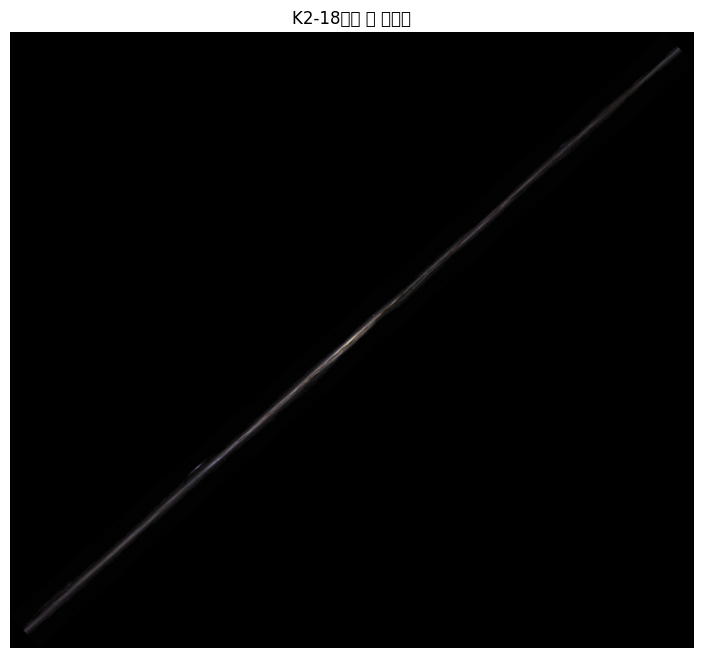

In [ ]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from PIL import Image
import matplotlib.pyplot as plt

# 외계 행성 데이터
exoplanets = {
    'K2-18': SkyCoord(
        ra='11h30m14.51774s',
        dec='+07d35m18.2553s',
        distance=38.10 * u.pc,
        frame='icrs'
    ),
    'Gliese_581': SkyCoord(
        ra='15h19m26.8250s',
        dec='-07d43m20.209s',
        distance=6.279 * u.pc,
        frame='icrs'
    )
}

# 은하수 중심의 ICRS 좌표 (지구 기준)
milky_way_center = SkyCoord(
    ra='17h45m40.04s',
    dec='-29d00m28.1s',
    distance=8000 * u.pc,  # 8.0 kpc
    frame='icrs'
)

# 은하수의 북쪽 (Galactic North Pole) ICRS 좌표
galactic_north_pole = SkyCoord(
    ra=192.85948 * u.deg,
    dec=27.12825 * u.deg,
    frame='icrs'
)

def get_relative_position(observer, target):
    """
    observer: SkyCoord of the observer
    target: SkyCoord of the target
    Returns: SkyCoord of target relative to observer
    """
    # 벡터 계산: observer를 원점으로 설정
    observer_cart = observer.cartesian
    target_cart = target.cartesian
    relative_cart = target_cart - observer_cart
    relative_distance = relative_cart.norm()
    relative_coord = SkyCoord(
        relative_cart,
        representation_type='cartesian',
        frame='icrs'
    ).spherical
    return SkyCoord(
        ra=relative_coord.lon,
        dec=relative_coord.lat,
        distance=relative_distance,
        frame='icrs'
    )

def calculate_inclination_position_angle(observer, target, disk_normal):
    """
    observer: SkyCoord of the observer
    target: SkyCoord of the target (Milky Way center)
    disk_normal: SkyCoord of the galaxy disk normal (Galactic North Pole)
    Returns: inclination and position angle in degrees
    """
    # 시선 벡터 (observer에서 target을 향한 벡터)
    relative = get_relative_position(observer, target)
    line_of_sight = relative.cartesian.xyz.value
    line_of_sight_unit = line_of_sight / np.linalg.norm(line_of_sight)

    # 은하수 원반의 법선 벡터
    disk_normal_cart = disk_normal.cartesian.xyz.value
    disk_normal_unit = disk_normal_cart / np.linalg.norm(disk_normal_cart)

    # 기울기(Inclination): 법선 벡터와 시선 벡터 사이의 각도
    inclination_rad = np.arccos(np.clip(np.dot(disk_normal_unit, line_of_sight_unit), -1.0, 1.0))
    inclination_deg = np.degrees(inclination_rad)

    # 기울기 각도를 0-90도로 제한
    inclination_deg = min(inclination_deg, 180 - inclination_deg)

    # 은하수 원반의 주요 축 방향 계산
    # 주요 축을 정의하기 위해 은하수의 동쪽 방향 단위 벡터 정의
    # 동쪽 방향 단위 벡터 (RA=90, Dec=0)
    east = SkyCoord(ra=90*u.deg, dec=0*u.deg, frame='icrs')
    east_cart = east.cartesian.xyz.value
    east_unit = east_cart / np.linalg.norm(east_cart)

    # 주요 축 벡터: disk_normal x east
    major_axis = np.cross(disk_normal_unit, east_unit)
    major_axis_unit = major_axis / np.linalg.norm(major_axis)

    # 투영된 주요 축 벡터 계산
    projection = major_axis_unit - np.dot(major_axis_unit, line_of_sight_unit) * line_of_sight_unit
    projection_norm = np.linalg.norm(projection)
    if projection_norm == 0:
        # 주요 축이 시선 벡터와 평행한 경우
        position_angle_deg = 0.0
    else:
        projection_unit = projection / projection_norm
        # 천구에서 북쪽(Dec=90) 방향 단위 벡터
        north = SkyCoord(ra=0*u.deg, dec=90*u.deg, frame='icrs')
        north_cart = north.cartesian.xyz.value
        north_unit = north_cart / np.linalg.norm(north_cart)
        # 투영된 주요 축과 북쪽 방향 사이의 각도
        dot_product = np.dot(projection_unit, north_unit)
        dot_product = np.clip(dot_product, -1.0, 1.0)
        angle_rad = np.arccos(dot_product)
        # 방향 결정 (동쪽 또는 서쪽)
        cross_prod = np.cross(north_unit, projection_unit)
        if cross_prod[2] < 0:
            angle_rad = -angle_rad
        position_angle_deg = np.degrees(angle_rad)
        # 위치 각도를 0~360도로 변환
        if position_angle_deg < 0:
            position_angle_deg += 360.0

    return inclination_deg, position_angle_deg

def transform_image(image_path, inclination, position_angle):
    """
    Apply scaling and rotation to the image based on inclination and position angle.
    """
    image = Image.open(image_path)
    image = image.convert('RGB')

    # 기울기(Inclination)를 반영하기 위해 세로 방향으로 축소
    # Inclination을 0-90도로 제한했으므로 scale_factor는 cos(0)=1에서 cos(90)=0 사이
    scale_factor = np.cos(np.radians(inclination))

    # 최소 scale_factor 설정하여 new_height가 0이 되지 않도록 함
    min_scale = 0.1
    if scale_factor < min_scale:
        scale_factor = min_scale

    new_height = max(int(image.height * scale_factor), 1)
    scaled_image = image.resize((image.width, new_height), resample=Image.BICUBIC)

    # 위치 각도(Position Angle)를 반영하기 위해 회전
    # PIL의 rotate는 시계 반대 방향으로 회전하므로, 시계 방향 회전을 위해 음수 각도 사용
    rotated_image = scaled_image.rotate(-position_angle, resample=Image.BICUBIC, expand=True)

    return rotated_image

# 외계 행성에서 본 은하수 파노라마 이미지 변환 및 저장
def generate_exoplanet_view_image(image_path, exoplanet_name, save_path=None):
    observer = exoplanets[exoplanet_name]
    relative_mw_center = get_relative_position(observer, milky_way_center)

    print(f"{exoplanet_name}에서 본 은하수 중심의 좌표:")
    print(f"  적경 (RA): {relative_mw_center.ra.to_string(unit=u.hour, sep='hms', precision=2)}")
    print(f"  적위 (Dec): {relative_mw_center.dec.to_string(unit=u.deg, sep='dms', precision=2)}")
    print(f"  거리: {relative_mw_center.distance.to(u.pc):.2f}\n")

    # 기울기 각도 및 위치 각도 계산
    inclination, position_angle = calculate_inclination_position_angle(observer, milky_way_center, galactic_north_pole)
    print(f"{exoplanet_name}에서의 기울기 각도 (Inclination): {inclination:.2f}도")
    print(f"{exoplanet_name}에서의 위치 각도 (Position Angle): {position_angle:.2f}도\n")

    # 이미지 변환
    transformed_image = transform_image(image_path, inclination, position_angle)

    # 변환된 이미지 저장 (선택 사항)
    if save_path:
        transformed_image.save(save_path)
        print(f"변환된 이미지를 {save_path}에 저장했습니다.")

    # 변환된 이미지 표시
    plt.figure(figsize=(12, 8))
    plt.imshow(transformed_image)
    plt.title(f'{exoplanet_name}에서 본 은하수')
    plt.axis('off')
    plt.show()

# 이미지 경로
image_path = '/content/drive/MyDrive/NASA2024/ModifiedGalaxyView.png'

# 외계 행성 선택 (예: 'K2-18' 또는 'Gliese_581')
selected_planet = 'K2-18'  # 또는 'Gliese_581'

# 변환된 이미지 저장 경로 (선택 사항)
save_image_path = f'/content/drive/MyDrive/NASA2024/TransformedGalaxyView_{selected_planet}.png'

# 변환 및 시각화 실행
generate_exoplanet_view_image(image_path, selected_planet, save_path=save_image_path)


In [ ]:
# 터미널에서 라이브러리 설치
!pip install astropy
!pip install astroquery
!pip install matplotlib
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 55.2 MB/s eta 0:00:00


In [ ]:
# 라이브러리 가져오기
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# 3D 시각화를 위한 라이브러리
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go


In [ ]:
# RA와 Dec의 구간 설정 (각각 30도 단위로 분할)
step_size = 10
ra_steps = np.arange(0, 360, step_size)  # 0, 30, 60, ..., 330

# 전체 구간 리스트 생성
ra_ranges = [(ra, ra + step_size) for ra in ra_steps]

In [ ]:
# 빈 데이터프레임 생성
all_data = pd.DataFrame()

# 총 쿼리 횟수 계산 (RA 구간 * Dec 구간)
total_queries = len(ra_ranges)

# 진행 상황 표시를 위한 tqdm 사용
with tqdm(total=total_queries, desc="Querying Gaia Data") as pbar:
    for ra_min, ra_max in ra_ranges:
        # RA와 Dec 조건을 쿼리에 추가
        query = f"""
        SELECT
            source_id, ra, dec, parallax, phot_g_mean_mag, bp_rp
        FROM
            gaiadr3.gaia_source
        WHERE
            ra BETWEEN {ra_min} AND {ra_max}
            AND parallax > 0
            AND phot_g_mean_mag < 16
        """
        try:
            # 쿼리 실행
            job = Gaia.launch_job_async(query)
            tmp_data = job.get_results()

            # pandas 데이터프레임으로 변환
            df = tmp_data.to_pandas()

            # 빈 데이터프레임이 아니면 병합
            if not df.empty:
                gaia_data = pd.concat([all_data, df], ignore_index=True)

        except Exception as e:
            print(f"Query failed for RA: {ra_min}-{ra_max}, Error: {e}")

        # 진행 상황 업데이트
        pbar.update(1)


Querying Gaia Data:   3%|▎         | 1/36 [01:46<1:02:13, 106.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:   6%|▌         | 2/36 [03:32<1:00:17, 106.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:   8%|▊         | 3/36 [05:28<1:00:54, 110.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  11%|█         | 4/36 [07:27<1:00:46, 113.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  14%|█▍        | 5/36 [09:11<57:00, 110.33s/it]  

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  17%|█▋        | 6/36 [11:13<57:08, 114.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  19%|█▉        | 7/36 [13:11<55:48, 115.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  22%|██▏       | 8/36 [15:46<59:48, 128.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  25%|██▌       | 9/36 [18:58<1:06:36, 148.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  28%|██▊       | 10/36 [23:04<1:17:15, 178.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  31%|███       | 11/36 [27:55<1:28:37, 212.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  33%|███▎      | 12/36 [32:57<1:35:56, 239.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  36%|███▌      | 13/36 [37:39<1:36:54, 252.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  39%|███▉      | 14/36 [41:07<1:27:39, 239.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  42%|████▏     | 15/36 [44:37<1:20:39, 230.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  44%|████▍     | 16/36 [47:51<1:13:11, 219.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  47%|████▋     | 17/36 [51:08<1:07:19, 212.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  50%|█████     | 18/36 [54:04<1:00:29, 201.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  53%|█████▎    | 19/36 [57:05<55:22, 195.42s/it]  

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  56%|█████▌    | 20/36 [1:00:18<51:53, 194.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  58%|█████▊    | 21/36 [1:03:48<49:47, 199.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  61%|██████    | 22/36 [1:07:11<46:48, 200.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  64%|██████▍   | 23/36 [1:11:04<45:31, 210.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  67%|██████▋   | 24/36 [1:15:50<46:35, 232.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  69%|██████▉   | 25/36 [1:21:27<48:25, 264.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  72%|███████▏  | 26/36 [1:28:06<50:47, 304.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  75%|███████▌  | 27/36 [1:34:19<48:46, 325.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  78%|███████▊  | 28/36 [1:40:42<45:41, 342.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  81%|████████  | 29/36 [1:47:14<41:41, 357.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  83%|████████▎ | 30/36 [1:53:14<35:47, 357.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  86%|████████▌ | 31/36 [1:58:28<28:43, 344.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  89%|████████▉ | 32/36 [2:02:05<20:26, 306.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  92%|█████████▏| 33/36 [2:05:10<13:30, 270.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  94%|█████████▍| 34/36 [2:07:48<07:52, 236.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data:  97%|█████████▋| 35/36 [2:10:00<03:25, 205.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.
Querying Gaia Data: 100%|██████████| 36/36 [2:11:53<00:00, 219.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
gaia_data.to_csv('Gaia_mag16_data.csv', mode='a', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gaia_data = pd.read_csv('/content/drive/MyDrive/NASA2024/Gaia_mag16_data.csv')

In [ ]:
# 거리 계산 (파섹 단위)
distances = 1000 / gaia_data['parallax'].values  # 거리 = 1 / 연주시차(초각)

# SkyCoord 객체 생성 (ICRS 좌표계)
stars_icrs = SkyCoord(ra=gaia_data['ra'].values*u.degree,
                      dec=gaia_data['dec'].values*u.degree,
                      distance=distances*u.pc,
                      frame='icrs')


In [ ]:
# 외계행성의 좌표 (예: K2-18b)
exoplanet_coord = SkyCoord(
    ra='11h30m14.51774s',
    dec='+07d35m18.2553s',
    distance=38.10 * u.pc,
    frame='icrs'
)


In [ ]:
# 관측자 위치를 원점으로 이동
observer_icrs = exoplanet_coord.icrs
relative_positions = stars_icrs.cartesian - observer_icrs.cartesian

# 새로운 좌표 생성
new_coords = SkyCoord(relative_positions, frame='icrs')


In [ ]:
# 새로운 거리 계산
new_distances = new_coords.distance.value

# 겉보기 등급 재계산
original_magnitudes = gaia_data['phot_g_mean_mag'].values
distance_modulus = 5 * np.log10(new_distances / distances)
new_magnitudes = original_magnitudes + distance_modulus

# 너무 어두운 별은 제외
visible = new_magnitudes < 16
visible_coords = new_coords[visible]
visible_magnitudes = new_magnitudes[visible]


In [ ]:
# 별들의 적경과 적위
ra_rad = visible_coords.ra.wrap_at(180 * u.degree).radian
dec_rad = visible_coords.dec.radian

# 별의 밝기를 점의 크기로 변환
sizes = 1 * 10 ** ( -0.2 * (visible_magnitudes))   # 밝을수록 큰 점


In [ ]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from PIL import Image
from scipy.ndimage import gaussian_filter

# 1. 데이터 로드 및 필터링

# CSV 파일 경로
csv_path = '/content/drive/MyDrive/NASA2024/Gaia_mag16_data.csv'

# GAIA 데이터 로드
gaia_data = pd.read_csv(csv_path)

# 너무 밝은 별 제외 (phot_g_mean_mag <= 6)
gaia_data = gaia_data[gaia_data['phot_g_mean_mag'] > 6]

# 2. 거리 계산 및 정규화

# GAIA 연주시차(parallax)는 밀리초각(mas) 단위
# 거리 계산 (파섹 단위)
distances = 1000 / gaia_data['parallax'].values  # 거리 = 1000 / parallax (mas -> pc)

# 거리 정규화: 모든 별의 거리를 1 pc로 설정
gaia_data['distance_normalized'] = 1.0  # 모든 별을 동일 거리로 설정

# SkyCoord 객체 생성 (ICRS 좌표계)
stars_icrs = SkyCoord(
    ra=gaia_data['ra'].values * u.degree,
    dec=gaia_data['dec'].values * u.degree,
    distance=gaia_data['distance_normalized'].values * u.pc,
    frame='icrs'
)

# 3. 외계행성 기준으로 좌표 변환

# 외계행성의 좌표 정의 (예: K2-18b)
exoplanet_coord = SkyCoord(
    ra='11h30m14.51774s',
    dec='+07d35m18.2553s',
    distance=38.10 * u.pc,
    frame='icrs'
)

# 관측자 위치를 원점으로 이동
relative_positions = stars_icrs.cartesian - exoplanet_coord.cartesian

# 새로운 SkyCoord 객체 생성 (외계행성 기준)
new_coords = SkyCoord(relative_positions, frame='icrs')

# 새로운 거리 계산 (모든 별의 거리를 1 pc로 정규화)
new_distances = new_coords.distance.value  # 거리 값은 1 pc

# 겉보기 등급 재계산 (거리 모듈러스)
original_magnitudes = gaia_data['phot_g_mean_mag'].values
distance_modulus = 5 * np.log10(new_distances / distances)
new_magnitudes = original_magnitudes + distance_modulus

# 너무 어두운 별 제외 (new_magnitudes >= 16)
visible = new_magnitudes < 16
visible_coords = new_coords[visible]
visible_magnitudes = new_magnitudes[visible]

# 추가적으로 유효한 RA와 Dec 범위 내에 있는지 확인
valid = (visible_coords.ra.deg >= 0) & (visible_coords.ra.deg < 360) & \
        (visible_coords.dec.deg >= -90) & (visible_coords.dec.deg <= 90)

visible_coords = visible_coords[valid]
visible_magnitudes = visible_magnitudes[valid]

# 4. 2D 투영 및 픽셀 매핑

# 별들의 적경과 적위를 라디안 단위로 가져오기
ra_rad = visible_coords.ra.wrap_at(180 * u.degree).radian  # -pi ~ pi
dec_rad = visible_coords.dec.radian  # -pi/2 ~ pi/2

# 이미지 해상도 설정 (고해상도)
img_width = 1000  # 가로 픽셀 수
img_height = 500  # 세로 픽셀 수

# RA와 Dec를 픽셀 좌표로 매핑
# RA: -pi ~ pi -> x: 0 ~ img_width
# Dec: -pi/2 ~ pi/2 -> y: 0 ~ img_height

x = ((ra_rad + np.pi) / (2 * np.pi)) * img_width
y = ((dec_rad + (np.pi / 2)) / np.pi) * img_height

# 정수형으로 변환
x_pix = np.floor(x).astype(int)
y_pix = np.floor(y).astype(int)

# 이미지 경계를 벗어난 좌표 제거
valid_pixels = (x_pix >= 0) & (x_pix < img_width) & (y_pix >= 0) & (y_pix < img_height)
x_pix = x_pix[valid_pixels]
y_pix = y_pix[valid_pixels]
visible_magnitudes = visible_magnitudes[valid_pixels]

# 5. 고해상도 이미지 생성 및 픽셀별 카운트

# 픽셀별 별 개수 카운트
# y축은 위쪽이 0, 아래쪽이 img_height
counts, xedges, yedges = np.histogram2d(
    y_pix, x_pix,
    bins=[img_height, img_width],
    range=[[0, img_height], [0, img_width]]
)

# 6. 별의 크기에 따라 여러 픽셀을 차지하도록 카운트 배열 확장

# Define the Gaussian kernel sigma based on desired star size
# 별 크기는 magnitude에 따라 조정할 수 있지만, 고정된 sigma를 사용하는 것이 효율적입니다
sigma = 2  # 픽셀 단위: 별의 크기에 따라 조정

# Apply Gaussian filter to spread counts over multiple pixels
counts_convolved = gaussian_filter(counts, sigma=sigma)

# 7. 카운트 배열 정규화 및 그레이스케일 이미지 생성

# 카운트 배열 정규화: 0 ~ 255
max_count = counts_convolved.max()
min_count = counts_convolved.min()

if max_count == min_count:
    normalized_counts = np.zeros_like(counts_convolved)
else:
    normalized_counts = (counts_convolved - min_count) / (max_count - min_count) * 255

# 데이터 타입을 uint8로 변환
image_array = normalized_counts.astype(np.uint8)

# y축을 위쪽으로 향하도록 뒤집기 (옵션)
image_array = np.flipud(image_array)

# 8. 이미지 생성 및 저장

# PIL을 사용하여 그레이스케일 이미지 생성
image = Image.fromarray(image_array, mode='L')  # 'L'은 8비트 그레이스케일

# 이미지 저장
output_filename = f'milky_way_from_K2-18.png'
image.save(output_filename)
print(f"이미지가 성공적으로 저장되었습니다: {output_filename}")

# 추가: 별의 밝기를 반영하여 픽셀 밝기 조정 (옵션)

# 만약 별의 밝기를 반영하여 픽셀의 밝기를 조정하고 싶다면, 별의 밝기를 가중치로 사용하여 별들이 여러 픽셀에 걸쳐 영향을 미치도록 처리할 수 있습니다.

# 예시: 별의 밝기(mag)를 가중치로 사용하여 픽셀 밝기를 조정

# 별의 밝기 계산 (brightness = 10^(-0.4 * mag))
brightness = 10 ** (-0.4 * visible_magnitudes)

# 각 픽셀에 해당하는 밝기 합계
brightness_counts, xedges, yedges = np.histogram2d(
    y_pix, x_pix,
    bins=[img_height, img_width],
    range=[[0, img_height], [0, img_width]],
    weights=brightness
)

# Gaussian filter을 적용하여 밝기 분포를 확장
brightness_convolved = gaussian_filter(brightness_counts, sigma=sigma)

# 밝기 배열 정규화: 0 ~ 255
max_brightness = brightness_convolved.max()
min_brightness = brightness_convolved.min()

if max_brightness == min_brightness:
    normalized_brightness = np.zeros_like(brightness_convolved)
else:
    normalized_brightness = (brightness_convolved - min_brightness) / (max_brightness - min_brightness) * 255

# 데이터 타입을 uint8로 변환
image_array_brightness = normalized_brightness.astype(np.uint8)

# y축을 위쪽으로 향하도록 뒤집기 (옵션)
image_array_brightness = np.flipud(image_array_brightness)

# PIL을 사용하여 그레이스케일 이미지 생성
image_brightness = Image.fromarray(image_array_brightness, mode='L')  # 'L'은 8비트 그레이스케일

# 이미지 저장
output_filename_brightness = f'milky_way_from_K2-18_brightness.png'
image_brightness.save(output_filename_brightness)
print(f"밝기가 반영된 이미지가 성공적으로 저장되었습니다: {output_filename_brightness}")


이미지가 성공적으로 저장되었습니다: milky_way_from_K2-18.png
밝기가 반영된 이미지가 성공적으로 저장되었습니다: milky_way_from_K2-18_brightness.png


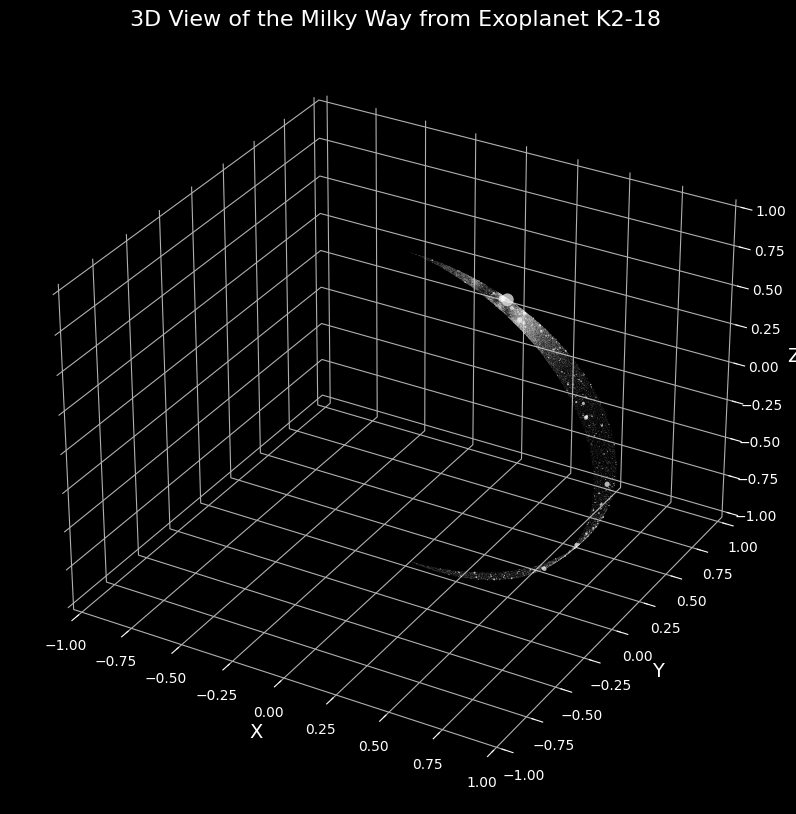

Matplotlib을 사용한 3D 이미지가 성공적으로 저장되었습니다: milky_way_3d_from_K2-18_matplotlib.png


In [ ]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 시각화를 위한 모듈

# 1. 데이터 로드 및 필터링

# CSV 파일 경로
csv_path = '/content/drive/MyDrive/NASA2024/Gaia_mag16_data.csv'

# GAIA 데이터 로드
gaia_data = pd.read_csv(csv_path)

# 너무 밝은 별 제외 (phot_g_mean_mag <= 6)
gaia_data = gaia_data[gaia_data['phot_g_mean_mag'] > 6]

# 2. 거리 계산 및 정규화

# GAIA 연주시차(parallax)는 밀리초각(mas) 단위
# 거리 계산 (파섹 단위)
distances = 1000 / gaia_data['parallax'].values  # 거리 = 1000 / parallax (mas -> pc)

# SkyCoord 객체 생성 (ICRS 좌표계)
stars_icrs = SkyCoord(
    ra=gaia_data['ra'].values * u.degree,
    dec=gaia_data['dec'].values * u.degree,
    distance=distances * u.pc,
    frame='icrs'
)

# 3. 외계행성 기준 좌표 변환

# 외계행성의 좌표 정의 (예: K2-18b)
exoplanet_coord = SkyCoord(
    ra='11h30m14.51774s',
    dec='+07d35m18.2553s',
    distance=38.10 * u.pc,
    frame='icrs'
)

# 관측자 위치를 원점으로 이동
relative_positions = stars_icrs.cartesian - exoplanet_coord.cartesian

# 새로운 SkyCoord 객체 생성 (외계행성 기준)
new_coords = SkyCoord(relative_positions, frame='icrs')

# 새로운 거리 계산 (모든 별의 거리를 1 pc로 정규화)
# 여기서는 모든 별의 거리를 동일하게 1 pc로 가정합니다.
new_distances = 1.0  # 모든 별의 거리를 1 pc로 설정

# 겉보기 등급 재계산 (거리 모듈러스 적용)
original_magnitudes = gaia_data['phot_g_mean_mag'].values
distance_modulus = 5 * np.log10(new_distances / distances)
new_magnitudes = original_magnitudes + distance_modulus

# 너무 어두운 별 제외 (new_magnitudes >= 16)
visible = new_magnitudes < 16
visible_coords = new_coords[visible]
visible_magnitudes = new_magnitudes[visible]

# 4. 3D 구면 좌표 계산

# 별들의 적경과 적위를 라디안 단위로 가져오기
ra_rad = visible_coords.ra.wrap_at(180 * u.degree).radian  # -pi ~ pi
dec_rad = visible_coords.dec.radian  # -pi/2 ~ pi/2

# 3D 구면 좌표 계산 (단위 구면)
x = np.cos(dec_rad) * np.cos(ra_rad)
y = np.cos(dec_rad) * np.sin(ra_rad)
z = np.sin(dec_rad)

# 5. 별의 크기 및 색상 설정

# 별의 밝기를 반영하여 점의 크기 설정 (밝을수록 큰 점)
# 기존 식을 사용: sizes = 0.01 * 10 ** (-0.2 * (visible_magnitudes))
sizes = 0.002 * 10 ** (-0.2 * visible_magnitudes)
"""
# 별의 색상 설정 (BP-RP 색 지수 활용)
bp_rp = gaia_data['bp_rp'].values[visible]

# BP-RP 값을 0 ~ 1로 정규화
bp_rp_normalized = (bp_rp - bp_rp.min()) / (bp_rp.max() - bp_rp.min())

# 컬러 맵 적용 (예: Plasma)
colors = plt.cm.plasma(bp_rp_normalized)
"""
colors = 'white'
# 6. 3D 시각화 설정

# 3D 플롯 생성
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 별 그리기
scatter = ax.scatter(x, y, z, s=sizes, c=colors, alpha=0.7, edgecolors='none')

# 축 라벨 설정
ax.set_xlabel('X', fontsize=14, color='white')
ax.set_ylabel('Y', fontsize=14, color='white')
ax.set_zlabel('Z', fontsize=14, color='white')

# 축의 범위를 [-1, 1]로 설정
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# 축의 눈금 및 라벨 색상 설정
ax.tick_params(colors='white')

# 배경색 설정
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# 축 라벨 색상 설정
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')

# 제목 설정
plt.title('3D View of the Milky Way from Exoplanet K2-18', color='white', fontsize=16)

# 축 틱 라벨 색상 설정
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))

# 3D 플롯 표시
plt.show()

# 이미지 저장 (옵션)
fig.savefig('milky_way_3d_from_K2-18_matplotlib.png', dpi=300, facecolor='black')
print("Matplotlib을 사용한 3D 이미지가 성공적으로 저장되었습니다: milky_way_3d_from_K2-18_matplotlib.png")


<ipython-input-13-56c49faf4b61>:45: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((0, 0, 0, 1.0))
<ipython-input-13-56c49faf4b61>:46: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((0, 0, 0, 1.0))
<ipython-input-13-56c49faf4b61>:47: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((0, 0, 0, 1.0))


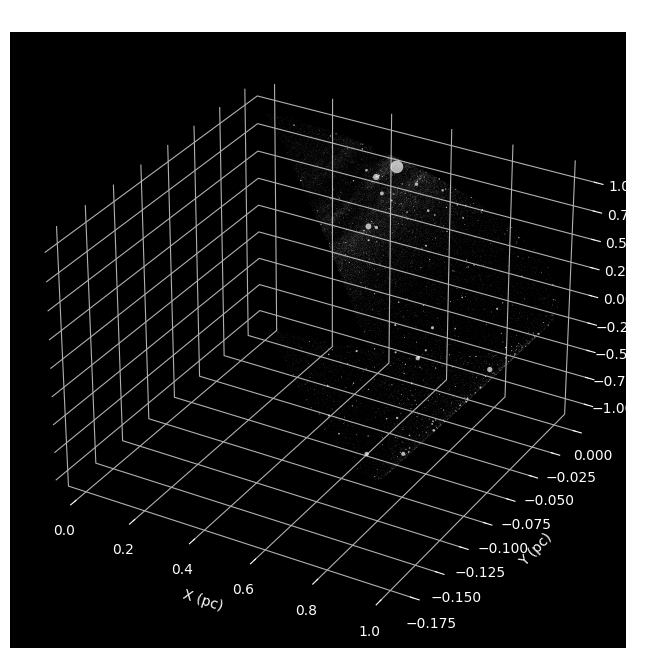

In [ ]:
# CSV 파일 경로
csv_path = '/content/drive/MyDrive/NASA2024/Gaia_mag16_data.csv'

# GAIA 데이터 로드
gaia_data = pd.read_csv(csv_path)

# 3D 시각화 준비
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')

# 별들의 좌표 (x, y, z)
x = visible_coords.cartesian.x.value
y = visible_coords.cartesian.y.value
z = visible_coords.cartesian.z.value

# 좌표 정규화: 각 별의 위치를 단위 구의 표면에 위치하도록 조정
positions = np.vstack((x, y, z)).T  # shape: (N, 3)
norms = np.linalg.norm(positions, axis=1).reshape(-1, 1)  # shape: (N, 1)
positions_normalized = positions / norms  # shape: (N, 3)

x_normalized = positions_normalized[:, 0]
y_normalized = positions_normalized[:, 1]
z_normalized = positions_normalized[:, 2]


# 별의 색상 설정 (BP-RP 색 지수 활용)
colors = 'white'

# 별 그리기
ax.scatter(x_normalized, y_normalized, z_normalized, s=sizes, c=colors, alpha=0.7, edgecolors='none')

# 축 라벨 설정
ax.set_xlabel('X (pc)', color='white')
ax.set_ylabel('Y (pc)', color='white')
ax.set_zlabel('Z (pc)', color='white')

# 축 색상 설정
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(colors='white')

# 배경 색상 설정
ax.w_xaxis.set_pane_color((0, 0, 0, 1.0))
ax.w_yaxis.set_pane_color((0, 0, 0, 1.0))
ax.w_zaxis.set_pane_color((0, 0, 0, 1.0))

# 제목 설정
plt.title(f'3D View of the Milky Way from Exoplanet K2-18', color='white')

# 그래프 표시
plt.show()

# 이미지 저장 (옵션)
fig.savefig(f'milky_way_3d_from_K2-18.png', dpi=300, facecolor='black')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# CSV 파일 경로
csv_path = '/content/drive/MyDrive/NASA2024/Gaia_mag16_data.csv'

# GAIA 데이터 로드
gaia_data = pd.read_csv(csv_path)

import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from PIL import Image
from scipy.ndimage import gaussian_filter

# 1. 데이터 로드 및 필터링

# CSV 파일 경로
csv_path = '/content/drive/MyDrive/NASA2024/Gaia_mag16_data.csv'

# GAIA 데이터 로드
gaia_data = pd.read_csv(csv_path)

# 너무 밝은 별 제외 (phot_g_mean_mag <= 6)
gaia_data = gaia_data[gaia_data['phot_g_mean_mag'] > 6]

# 2. 거리 계산 및 정규화

# GAIA 연주시차(parallax)는 밀리초각(mas) 단위
# 거리 계산 (파섹 단위)
distances = 1000 / gaia_data['parallax'].values  # 거리 = 1000 / parallax (mas -> pc)

# 거리 정규화: 모든 별의 거리를 1 pc로 설정
gaia_data['distance_normalized'] = 1.0  # 모든 별을 동일 거리로 설정

# SkyCoord 객체 생성 (ICRS 좌표계)
stars_icrs = SkyCoord(
    ra=gaia_data['ra'].values * u.degree,
    dec=gaia_data['dec'].values * u.degree,
    distance=gaia_data['distance_normalized'].values * u.pc,
    frame='icrs'
)

# 3. 외계행성 기준으로 좌표 변환

# 외계행성의 좌표 정의 (예: K2-18b)
exoplanet_coord = SkyCoord(
    ra='11h30m14.51774s',
    dec='+07d35m18.2553s',
    distance=38.10 * u.pc,
    frame='icrs'
)

# 관측자 위치를 원점으로 이동
relative_positions = stars_icrs.cartesian - exoplanet_coord.cartesian

# 새로운 SkyCoord 객체 생성 (외계행성 기준)
new_coords = SkyCoord(relative_positions, frame='icrs')

# 새로운 거리 계산 (모든 별의 거리를 1 pc로 정규화)
new_distances = new_coords.distance.value  # 거리 값은 1 pc

# 겉보기 등급 재계산 (거리 모듈러스)
original_magnitudes = gaia_data['phot_g_mean_mag'].values
distance_modulus = 5 * np.log10(new_distances / distances)
new_magnitudes = original_magnitudes + distance_modulus

# 너무 어두운 별 제외 (new_magnitudes >= 16)
visible = new_magnitudes < 16
visible_coords = new_coords[visible]

# 별들의 좌표 (x, y, z)
x = visible_coords.cartesian.x.value
y = visible_coords.cartesian.y.value
z = visible_coords.cartesian.z.value

# 좌표 정규화
positions = np.vstack((x, y, z)).T
norms = np.linalg.norm(positions, axis=1).reshape(-1, 1)
positions_normalized = positions / norms

x_normalized = positions_normalized[:, 0]
y_normalized = positions_normalized[:, 1]
z_normalized = positions_normalized[:, 2]

def save_skybox_image(ax, azim, elev, filename):
    ax.view_init(elev=elev, azim=azim)
    plt.savefig(filename, dpi=300, facecolor='black', bbox_inches='tight', pad_inches=0)

# 3D 시각화 준비
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')

# 별 그리기
colors = 'white'
sizes = 0.01 * 10 ** (-0.2 * visible_magnitudes)
ax.scatter(x_normalized, y_normalized, z_normalized, s=sizes, c=colors, alpha=0.7, edgecolors='none')

# 축 라벨 및 색상 설정
ax.set_xlabel('X (pc)', color='white')
ax.set_ylabel('Y (pc)', color='white')
ax.set_zlabel('Z (pc)', color='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(colors='white')
ax.w_xaxis.set_pane_color((0, 0, 0, 1.0))
ax.w_yaxis.set_pane_color((0, 0, 0, 1.0))
ax.w_zaxis.set_pane_color((0, 0, 0, 1.0))
ax.set_axis_off()

# 캡처할 각 방향 설정
views = {
    'front': {'azim': 0, 'elev': 0},
    'right': {'azim': 90, 'elev': 0},
    'back': {'azim': 180, 'elev': 0},
    'left': {'azim': -90, 'elev': 0},
    'top': {'azim': 0, 'elev': 90},
    'bottom': {'azim': 0, 'elev': -90}
}

# 각 방향에서 이미지 저장
for direction, angles in views.items():
    save_skybox_image(ax, angles['azim'], angles['elev'], f'milky_way_3d_from_K2-18_{direction}.png')

plt.close(fig)

<ipython-input-19-172d7f37d8fe>:111: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((0, 0, 0, 1.0))
<ipython-input-19-172d7f37d8fe>:112: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((0, 0, 0, 1.0))
<ipython-input-19-172d7f37d8fe>:113: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((0, 0, 0, 1.0))
